# Задание 4

Давайте посчитаем те же показатели, но в другом разрезе — не просто по дням, а по дням недели.

Задание:

Для каждого дня недели в таблицах orders и user_actions рассчитайте следующие показатели:

1. Выручку на пользователя (ARPU).
2. Выручку на платящего пользователя (ARPPU).
3. Выручку на заказ (AOV).
При расчётах учитывайте данные только за период с 26 августа 2022 года по 8 сентября 2022 года включительно — так, чтобы в анализ попало одинаковое количество всех дней недели (ровно по два дня).

В результирующую таблицу включите как наименования дней недели (например, Monday), так и порядковый номер дня недели (от 1 до 7, где 1 — это Monday, 7 — это Sunday).

Колонки с показателями назовите соответственно arpu, arppu, aov. Колонку с наименованием дня недели назовите weekday, а колонку с порядковым номером дня недели weekday_number.

При расчёте всех показателей округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию порядкового номера дня недели.

Поля в результирующей таблице: 

weekday, weekday_number, arpu, arppu, aov

```sql
with revenue_by_dow AS (
  SELECT
    to_char(date, 'Day') AS weekday,
    DATE_PART('isodow', date) AS weekday_number,
    sum(price) AS revenue
  FROM
    (
      SELECT
        unnest_query.date,
        unnest_query.product_id,
        products.price AS price
      FROM
        (
          SELECT
            order_id,
            creation_time :: date AS date,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS unnest_query
        JOIN products using (product_id)
      WHERE
        unnest_query.order_id NOT in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
        AND unnest_query.date BETWEEN '2022-08-26'
        AND '2022-09-09'
    ) AS subq
  GROUP BY
    1,
    2
),
total_users_table AS (
  SELECT
    to_char(time, 'Day') AS weekday,
    date_part('isodow', time) AS weekday_number,
    count(distinct user_id) AS total_users
  FROM
    user_actions
  WHERE
    time :: date BETWEEN '2022-08-26'
    AND '2022-09-09'
  GROUP BY
    1,
    2
),
paying_users_table AS (
  SELECT
    to_char(time, 'Day') AS weekday,
    date_part('isodow', time) AS weekday_number,
    count(distinct user_id) AS paying_users
  FROM
    user_actions
  WHERE
    order_id NOT in (
      SELECT
        order_id
      FROM
        user_actions
      WHERE
        action = 'cancel_order'
    )
    AND time :: date BETWEEN '2022-08-26'
    AND '2022-09-09'
  GROUP BY
    1,
    2
),
orders_table AS (
  SELECT
    to_char(creation_time, 'Day') AS weekday,
    date_part('isodow', creation_time) AS weekday_number,
    count(distinct order_id) AS act_orders
  FROM
    orders
  WHERE
    order_id NOT in (
      SELECT
        order_id
      FROM
        user_actions
      WHERE
        action = 'cancel_order'
    )
    AND creation_time :: date BETWEEN '2022-08-26'
    AND '2022-09-09'
  GROUP BY
    1,
    2
)
SELECT
  total_users_table.weekday,
  weekday_number,
  round(revenue / total_users :: decimal, 2) AS arpu,
  round(revenue / paying_users :: decimal, 2) AS arppu,
  round(revenue / act_orders :: decimal, 2) AS aov
FROM
  total_users_table
  JOIN revenue_by_dow using (weekday_number)
  JOIN paying_users_table using (weekday_number)
  JOIN orders_table using (weekday_number)
ORDER BY
  2
```

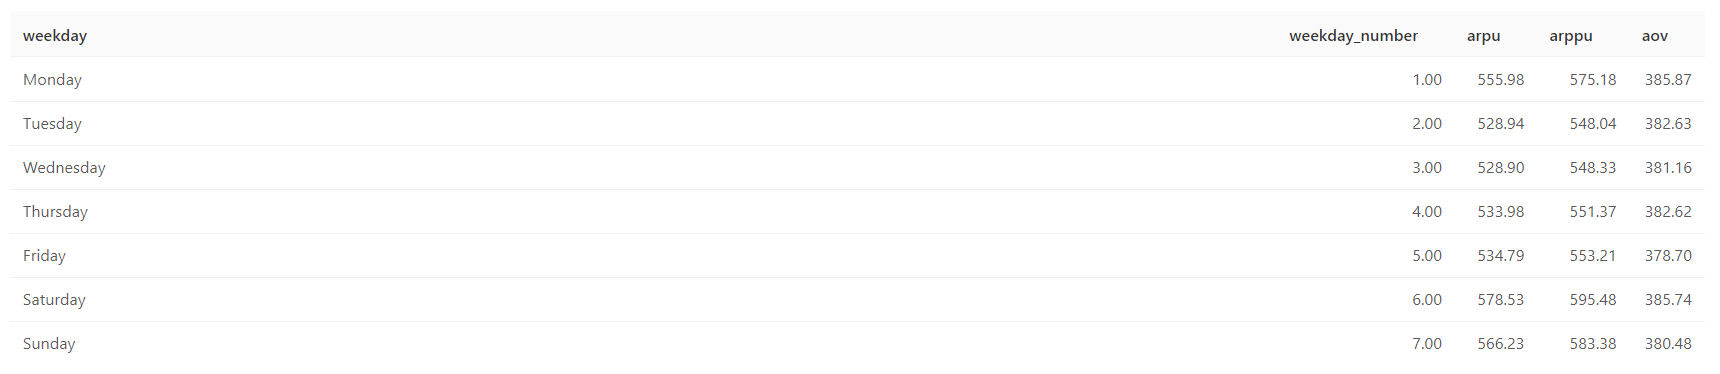

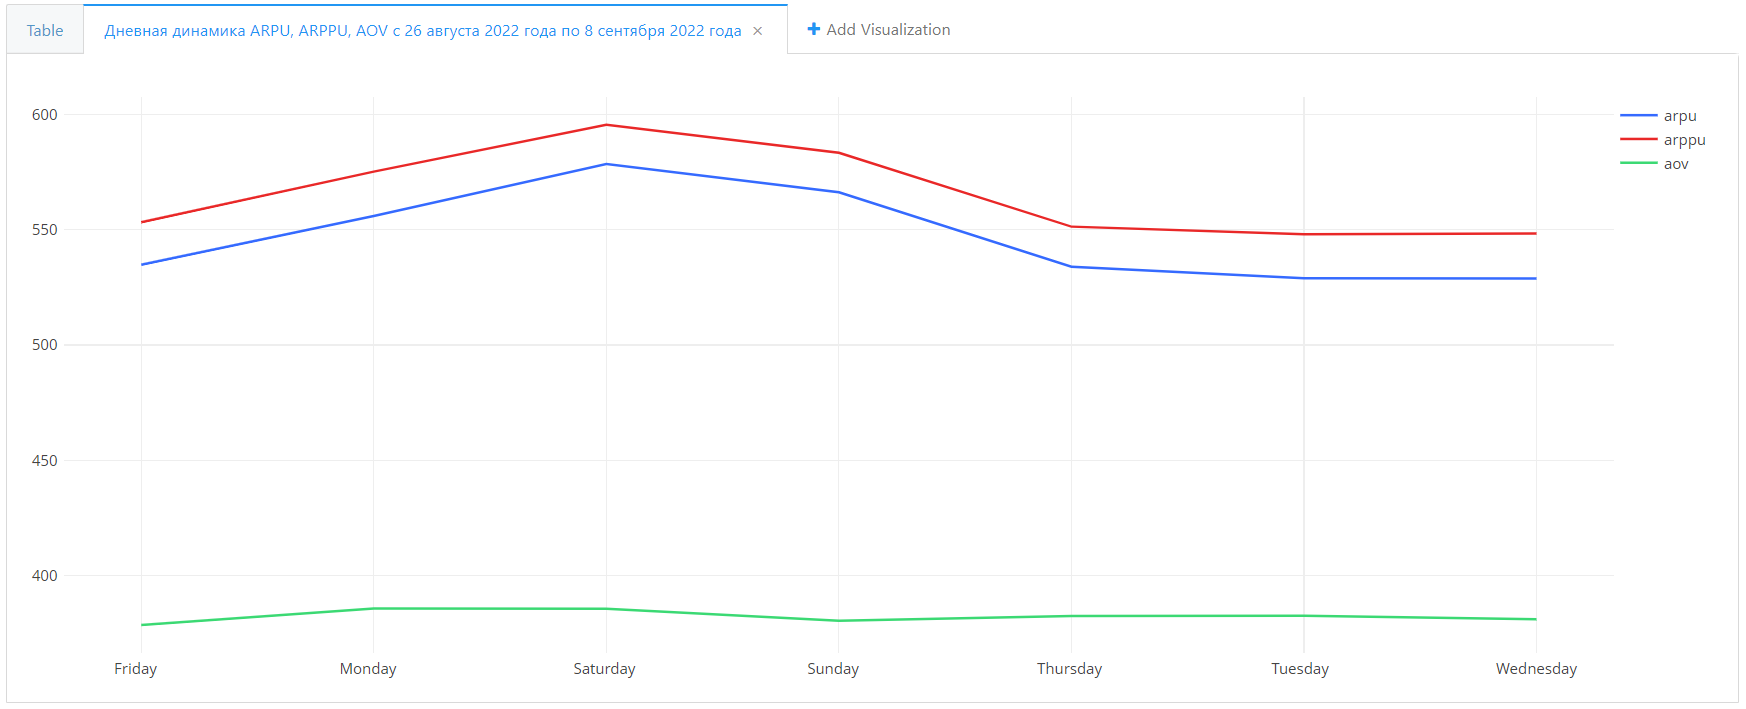